In [104]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [105]:
import numpy as np
import pandas as pd

In [106]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [107]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, aliased
from sqlalchemy import create_engine, func, inspect, and_

In [108]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [109]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [110]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [111]:
# Measurement = measurement

In [112]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [113]:
inspector = inspect(engine)

In [114]:
for tbl in inspector.get_table_names():
    print(tbl)

measurement
station


In [115]:
# Use Inspector to print the column names and types
for tbl in Base.classes.keys():
    columns = inspector.get_columns(tbl)
    print (f'Columns for Table:{tbl}')
    for c in columns:
        print(c['name'], c["type"])
    print (f'********************')

Columns for Table:measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
********************
Columns for Table:station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
********************


In [116]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [117]:
query_date_now = dt.datetime.now().replace(dt.datetime.now().year-1)
query_date = dt.datetime(2017,8,23).replace(dt.datetime(2017,8,23).year-1)
print("Query Date: ", query_date_now)
print("Query Date: ", query_date)

Query Date:  2018-02-01 15:54:54.990809
Query Date:  2016-08-23 00:00:00


In [118]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

print(session.query(Measurement.id,Measurement.station,Measurement.date,Measurement.prcp ,Measurement.tobs ).\
      filter(Measurement.date > query_date_now).all())
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# print(last_date[0])
last_date_dt = dt.datetime.strptime(last_date[0], '%Y-%m-%d').date()
# print(last_date_dt)
year_ago_from_last_date = last_date_dt.replace(last_date_dt.year-1)

print(f'date 1 year ago from the last data point in the database: {year_ago_from_last_date}')
# Latest Date
print(f'Latest Date: {last_date_dt}')

# Perform a query to retrieve the data and precipitation scores
result= session.query(Measurement.id,Measurement.station,Measurement.date,Measurement.prcp ,Measurement.tobs ).filter(Measurement.date >= year_ago_from_last_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(result, columns=['id','station','date','prcp','tobs'])
df.set_index('date', inplace=True )
df.head(10)
df.info()
df.index=pd.to_datetime(df.index)
# Sort the dataframe by date
df.sort_values(by='date',inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
df.reset_index(inplace=True)
df.sort_values('date',inplace=True)
df.head()


[]
date 1 year ago from the last data point in the database: 2016-08-23
Latest Date: 2017-08-23
<class 'pandas.core.frame.DataFrame'>
Index: 2230 entries, 2016-08-23 to 2017-08-23
Data columns (total 4 columns):
id         2230 non-null int64
station    2230 non-null object
prcp       2021 non-null float64
tobs       2230 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 87.1+ KB


,date,id,station,prcp,tobs
0,2016-08-23,2364,USC00519397,0.00,81.0
1,2016-08-23,8825,USC00517948,NaN,80.0
2,2016-08-23,14608,USC00519281,1.79,77.0
3,2016-08-23,7331,USC00514830,0.05,80.0
4,2016-08-23,5091,USC00513117,0.15,76.0


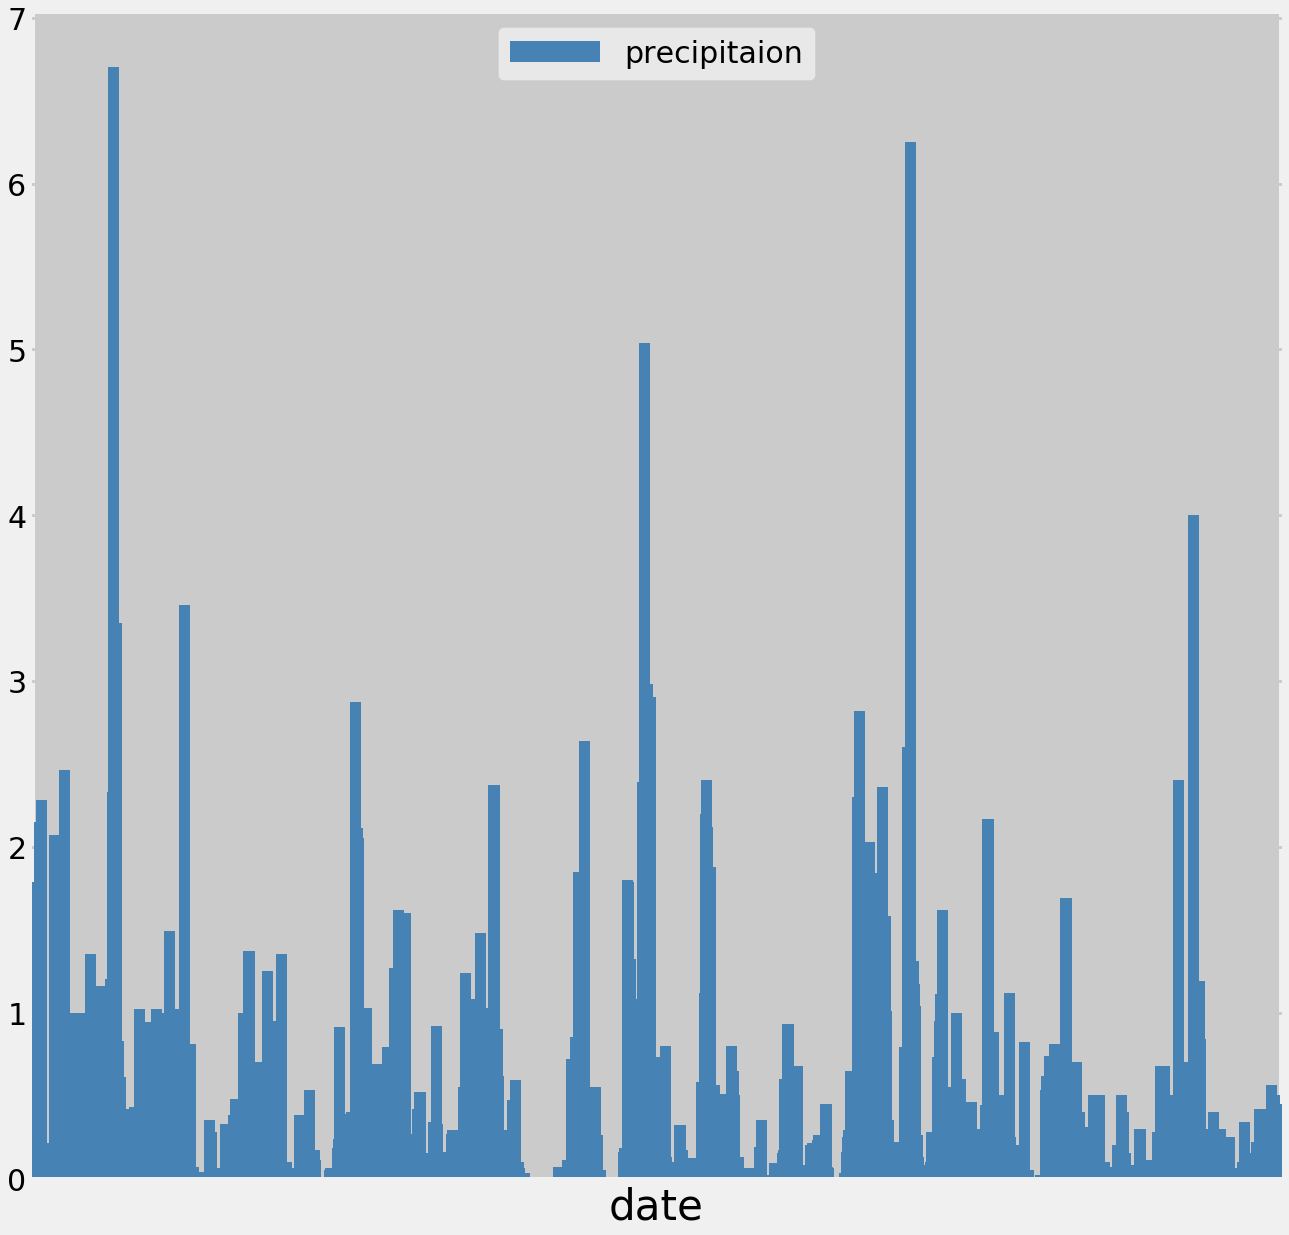

In [119]:

ax=df.plot(kind='bar',x='date',y='prcp',figsize=(20,20),grid=True,color='steelblue',width=20.0,
           joinstyle='round')
plt.xticks=[]
plt.legend(labels=['precipitaion'],loc=9,fontsize ='x-large', handlelength=3,prop={'size':30})
ax.grid(  linestyle='-',linewidth='3.0')
ax.set_xticklabels([''])
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xlabel('date',size=42)
plt.show()
ax.grid(linestyle='-', linewidth='0.5', color='red')

![precipitation](Images/precipitation.png)

In [120]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp_stat = pd.DataFrame(df['prcp'].describe())
df_prcp_stat.rename({'prcp':'precipitation'},axis=1,inplace=True)
df_prcp_stat

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [121]:
# Design a query to show how many stations are available in this dataset?
# station_count = session.query(func.count('*')).select_from(Measurement).scalar()
station_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(station_count)


9


In [122]:
# str(session.query(Measurement.station, func.count(Measurement.station)).\
#             group_by(Measurement.station).\
#             order_by(func.count(Measurement.station).desc()))

In [123]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).first()
print (f'Most Active Station: {most_active}')
print(f'\n')

print (f'****************************************************')
print (f'List the stations and the counts in descending order')
print (f'****************************************************')
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()



Most Active Station: ('USC00519281', 2772)


****************************************************
List the stations and the counts in descending order
****************************************************


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [124]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
min_temp = session.query(func.min(Measurement.tobs )).\
            filter(Measurement.station == 'USC00519281').all()
max_temp = session.query(func.max(Measurement.tobs )).\
            filter(Measurement.station == 'USC00519281').all()
ave_temp = session.query(func.avg(Measurement.tobs )).\
            filter(Measurement.station == 'USC00519281').all()

print(f'The lowest temperature for most active station : {min_temp[0][0]}')
print(f'The highest temperature for most active station: {max_temp[0][0]}')
print(f'The average temperature for most active station: {round(ave_temp[0][0],2)}')

The lowest temperature for most active station : 54.0
The highest temperature for most active station: 85.0
The average temperature for most active station: 71.66


In [125]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_ht = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()[0]
print(f'the station with the highest number of temperature observations: {station_ht}')
## I am using one year before from latest date in data
# subq = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
# order_by(func.count(Measurement.tobs).desc()).subquery
# aliassubq =aliased(Measurement,subq)

mainq = session.query(Measurement.id,Measurement.station,Measurement.date,  Measurement.prcp, Measurement.tobs).\
            filter(Measurement.date >= year_ago_from_last_date, Measurement.station=='USC00519281').all()

df_tobs = pd.DataFrame(mainq, columns=['id','station','date','prcp','tobs'])
df_tobs.head()


the station with the highest number of temperature observations: USC00519281


,id,station,date,prcp,tobs
0,14608,USC00519281,2016-08-23,1.79,77.0
1,14609,USC00519281,2016-08-24,2.15,77.0
2,14610,USC00519281,2016-08-25,0.06,80.0
3,14611,USC00519281,2016-08-26,0.01,80.0
4,14612,USC00519281,2016-08-27,0.12,75.0


In [126]:
df_tobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 5 columns):
id         352 non-null int64
station    352 non-null object
date       352 non-null object
prcp       352 non-null float64
tobs       352 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 13.8+ KB


In [127]:
df_tobs.describe()

,id,prcp,tobs
count,352.000000,352.000000,352.000000
mean,14783.500000,0.198949,73.107955
std,101.757883,0.419182,4.733315
min,14608.000000,0.000000,59.000000
25%,14695.750000,0.000000,70.000000
50%,14783.500000,0.060000,74.000000
75%,14871.250000,0.190000,77.000000
max,14959.000000,2.980000,83.000000


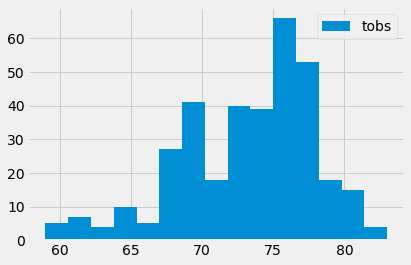

In [128]:
# fig=plt.plot(figsize=(10,8))

ax = plt.hist(x=df_tobs['tobs'],bins=15)
plt.legend(['tobs'])
plt.show()

![precipitation](Images/station-histogram.png)

In [129]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-01', '2017-02-16'))

[(59.0, 69.80952380952381, 80.0)]


In [130]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_out = calc_temps('2017-02-01', '2017-02-16')
calc_out
tmin = calc_out[0][0]
tave = calc_out[0][1]
tmax = calc_out[0][2]

yerr=[tmax-tmin]



In [131]:
df_t = pd.DataFrame({'tave':tave},index=['1'])
print(df_t)

        tave
1  69.809524


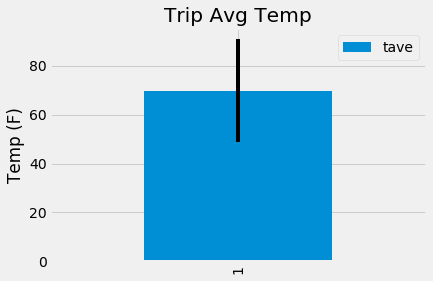

In [132]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.Figure(figsize=(0.1,40))
ax = df_t.loc[:,['tave']].plot(kind = 'bar',yerr = yerr)
plt.title('Trip Avg Temp')
ax.set_ylabel('Temp (F)')
plt.show()

##### Below query is for one year back from last data point. So query is printed if out put is different than expected for date range selected

In [133]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain= session.query(Measurement.station,func.sum(Measurement.prcp).label('total_rain')).group_by(Measurement.station)\
                    .filter(Measurement.date >= year_ago_from_last_date).subquery()

# print(rain)
station_rain = session.query(Station.station,Station.name, Station.latitude, Station.longitude, Station.elevation,\
                             rain.c.total_rain).join(rain,Station.station==rain.c.station)\
                .order_by(rain.c.total_rain.desc())
print(station_rain)
station_rain.all()

SELECT station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation, anon_1.total_rain AS anon_1_total_rain 
FROM station JOIN (SELECT measurement.station AS station, sum(measurement.prcp) AS total_rain 
FROM measurement 
WHERE measurement.date >= ? GROUP BY measurement.station) AS anon_1 ON station.station = anon_1.station ORDER BY anon_1.total_rain DESC


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  147.81000000000006),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  70.03000000000003),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  48.510000000000026),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  38.01),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  33.239999999999995),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  16.089999999999986),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59)]

## Optional Challenge Assignment

In [134]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [135]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime(2017,2,1)
# start_date =  start_date + dt.timedelta(days=1)
# print(start_date)
end_date = dt.datetime(2017,2,16)
# print(end_date)
# Use the start and end date to create a range of dates
list_trip_dates = [dt.datetime.strptime(f"{start_date.year}-{start_date.month}-{d}", '%Y-%m-%d').date()\
                   for d in range(start_date.day, end_date.day+1)]
# print(list_trip_dates)
# Stip off the year and save a list of %m-%d strings
list_trip_m_d = [ f'{d.strftime("%m")}-{d.strftime("%d")}' for d in list_trip_dates]
# print(list_trip_m_d)
# Loop through the list of %m-%d strings and calculate the normals for each date
list_d_normals = [daily_normals(i) for i in list_trip_m_d]
# list_d_normals = [list_d_normals[d[0]] for d[0] in list_d_normals]
print(list_d_normals)
# [d[0] for d in list_d_normals]

[[(56.0, 68.14035087719299, 78.0)], [(59.0, 68.85964912280701, 77.0)], [(58.0, 67.79661016949153, 77.0)], [(61.0, 68.14035087719299, 76.0)], [(59.0, 69.6842105263158, 80.0)], [(58.0, 70.38983050847457, 77.0)], [(60.0, 69.0, 77.0)], [(56.0, 66.75438596491227, 74.0)], [(57.0, 67.58928571428571, 75.0)], [(56.0, 68.41666666666667, 76.0)], [(61.0, 69.25, 79.0)], [(60.0, 69.15789473684211, 78.0)], [(58.0, 70.36206896551724, 80.0)], [(62.0, 70.89473684210526, 79.0)], [(56.0, 70.28813559322033, 79.0)], [(59.0, 70.48214285714286, 76.0)]]


In [136]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
final_dn = zip(list_trip_dates, list_d_normals)
# print(dict(final_dn))
df_daily_normals=pd.DataFrame(data=dict(final_dn)).T
tmin = []
tave = []
tmax = []
for index in range(0,len(df_daily_normals.index)):
    tmin.append(df_daily_normals.iloc[index][0][0])
    tave.append(df_daily_normals.iloc[index][0][1])
    tmax.append(df_daily_normals.iloc[index][0][2])

df_daily_normals['tmin']=tmin
df_daily_normals['tave']=tave
df_daily_normals['tmax']=tmax
df_daily_normals.drop(0,axis=1,inplace=True)
df_daily_normals.index.names = ['date']
df_daily_normals.head()


,tmin,tave,tmax
date,,,
2017-02-01,56.0,68.140351,78.0
2017-02-02,59.0,68.859649,77.0
2017-02-03,58.0,67.796610,77.0
2017-02-04,61.0,68.140351,76.0
2017-02-05,59.0,69.684211,80.0


In [137]:
# df_daily_normals.reset_index(inplace=True)
# df_daily_normals.head()

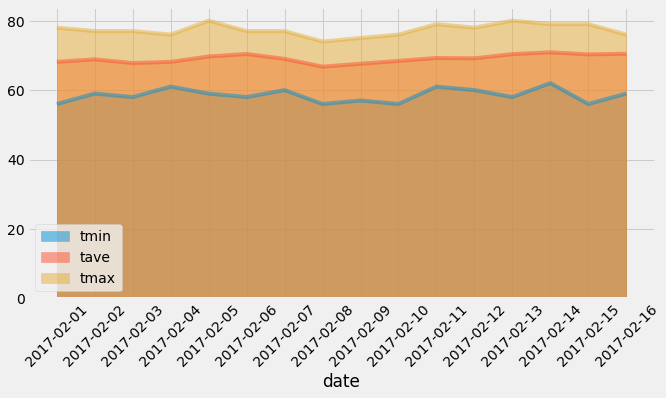

In [138]:
# Plot the daily normals as an area plot with `stacked=False`


ax=df_daily_normals.plot.area(stacked=False,figsize=(10,5))
ax.set_xticklabels(df_daily_normals.index.values,rotation=45)
ax.set_yticks(range(0,100,20))
ax.set_yticklabels(range(0,100,20))
ax.set_xticks(df_daily_normals.index.values)
